<a href="https://colab.research.google.com/github/2022-vacation-project-GLC/model/blob/main/resnet_cmu_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from astropy.table import Table

d = Table.read('/content/drive/MyDrive/catalogs.hdf5')

In [ ]:
import numpy as np

x = np.array(d['image'][:16000]).reshape((-1, 101, 101, 1))
y = np.array(d['is_lens'][:16000]).reshape((-1, 1))

x_test = np.array(d['image'][16000:]).reshape((-1, 101, 101, 1))
y_test = np.array(d['is_lens'][16000:]).reshape((-1, 1))

In [ ]:
import os
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

#datagenerator 생성
datagenerator_1 = ImageDataGenerator(
                                    rotation_range = 120,
                                    vertical_flip = True,
                                    horizontal_flip = True)

datagenerator_2 = ImageDataGenerator(
                                    rotation_range = 90,
                                    vertical_flip = False,
                                    horizontal_flip = True)

def generating1(x,y):
  x0 = np.array(x)
  y0 = np.array(y)
  p = datagenerator_1.flow(x0,y0,batch_size=len(x)-800)
  # print(len(x))

  return p

def generating2(x,y):
  x0 = np.array(x)
  y0 = np.array(y)
  p = datagenerator_2.flow(x0,y0,batch_size=len(x)-3000)
  # print(len(x))

  return p

def data_shuffle(x,y):
  xt = []
  yt = []
  entire = list(zip(x,y))
  random.shuffle(entire)

  for i in range(len(x)):
    xt.append(entire[i][0])
    yt.append(entire[i][1])

  x = np.asarray(xt).astype(np.float32)
  y = np.asarray(yt).astype(np.float32)

  return x, y

def data_rate(x,y):
  xt = []
  yt = []
  xf = []
  yf = []

  for i in range(len(y)):
    if y[i] ==1:
      xt.append(x[i])
      yt.append(y[i])
    else:
      xf.append(x[i])
      yf.append(y[i])

  xt = xt[:len(xf)]
  yt = yt[:len(yf)]
  x = xt+xf
  y = yt+yf
  x = np.asarray(x).astype(np.float32)
  y = np.asarray(y).astype(np.float32)


  return x,y

x0 = []
x1 = []

for i in range(len(x)):
  if y[i]==0:
    x0.append(x[i])
  elif y[i]==1:
    x1.append(x[i])

y0 = [0]*len(x0)
y1 = [1]*len(x1)

x = list(x)
y = list(y)

im,lb = generating1(x0,y0).next()
im1,lb1 = generating2(x1,y1).next()

for i in range(len(im)):
  x0.append(im[i])
  y0.append(lb[i])
for i in range(len(im1)):
  x1.append(im1[i])
  y1.append(lb1[i])



x1 = x1[:len(x0)]
y1 = y1[:len(y0)]

print(len(x1))
print(len(x0))

x = x0+x1
y = y0+y1

x_test,y_test = data_rate(x_test,y_test)

rate =0
rate1=0

for data in y:
  if data ==1:
    rate+=1

for data in y_test:
  if data ==1:
    rate1+=1

print(rate/len(y))

print(len(x))
x,y = data_shuffle(x,y)





'''
im, lb = generating(x0,y)

p1 = datagenerator_1.flow(x,y,batch_size=16000)
p2 = datagenerator_2.flow(x,y,batch_size=6000)
x = list(x)
y = list(y)

xa,ya = p1.next()
xaa,yaa = p2.next()
xa = np.array(xa)
ya = np.array(ya)
xaa = np.array(xaa)
yaa = np.array(yaa)

for i in range(len(xa)):
  x.append(xa[i])
  y.append(ya[i])

for i in range(len(xaa)):
  x.append(xaa[i])
  y.append(yaa[i])

x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)
'''

8868
8868
0.5
17736


'\nim, lb = generating(x0,y)\n\np1 = datagenerator_1.flow(x,y,batch_size=16000)\np2 = datagenerator_2.flow(x,y,batch_size=6000)\nx = list(x)\ny = list(y)\n\nxa,ya = p1.next()\nxaa,yaa = p2.next()\nxa = np.array(xa)\nya = np.array(ya)\nxaa = np.array(xaa)\nyaa = np.array(yaa)\n\nfor i in range(len(xa)):\n  x.append(xa[i])\n  y.append(ya[i])\n\nfor i in range(len(xaa)):\n  x.append(xaa[i])\n  y.append(yaa[i])\n\nx = np.array(x)\ny = np.array(y)\n\nprint(x.shape)\nprint(y.shape)\n'

In [ ]:
vmin = -1e-9
vmax = 1e-9
scale = 100

mask = np.where(x == 100)
mask_test = np.where(x_test == 100)

x[mask] = 0
x_test[mask_test] = 0

x = np.clip(x, vmin, vmax)/vmax * scale
x_test = np.clip(x_test, vmin, vmax)/vmax * scale

x[mask] = 0
x_test[mask_test] = 0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def resnet_block(input_layer, num_cnn=3, channel=64, block_num=1):
  x = input_layer
  for cnn_num in range(num_cnn):
    identity = x
    x = layers.Conv2D(filters=channel, kernel_size=(1,1), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=channel, kernel_size=(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=2*channel, kernel_size=(1,1), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    #x = layers.BatchNormalization()(x)
  
  # identity_channel = identity.shape.as_list()[-1]
  # x_channel = x.shape.as_list()[-1]
  # if  identity_channel != x_channel :
  #     identity = layers.Conv2D(x_channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
  # x = layers.Add()([x,identity])
  x = layers.MaxPooling2D(pool_size=(2,2))(x)

  return x

def build_resnet(input_shape=(101,101,1), num_cnn_list=[3,4,6,3], channel_list=[64,128,256,512], num_classes=2):
  assert len(num_cnn_list) == len(channel_list)

  input_layer = layers.Input(shape=input_shape)
  output = input_layer
  output = layers.Conv2D(filters=16, kernel_size=(7,7), kernel_initializer='he_normal', padding='same')(output)
  output = layers.BatchNormalization()(output)

  #output = layers.MaxPooling2D(pool_size=(2,2))(output)

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    output = resnet_block(output, num_cnn=num_cnn, channel=channel, block_num=i)

  output = layers.AveragePooling2D(padding='same')(output)
  output = layers.Flatten()(output)
  #output = layers.Dropout(0.35)(output)
  output = layers.Dense(1, activation='sigmoid')(output)

  model = tf.keras.Model(inputs=input_layer, outputs=output)
  return model

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.9 MB/s 


In [ ]:
import tensorflow_addons as tfa

resnet = build_resnet(num_cnn_list=[3,3,3,3,3], channel_list=[16,32,64,128,256])

first_decay_steps = 1000
initial_learning_rate = 0.01

wd = lambda: 1e-4
optimizer = tfa.optimizers.AdamW(weight_decay=wd)

resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101, 101, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 101, 101, 16)      800       
                                                                 
 batch_normalization (BatchN  (None, 101, 101, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 101, 16)      272       
                                                                 
 batch_normalization_1 (Batc  (None, 101, 101, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 101, 101, 16)      2320  

In [ ]:
stop = tf.keras.callbacks.EarlyStopping()

period = 1
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/real_final_model/model_{epoch}.ckpt', save_weights_only=False, verbose=1, period=period)

hist = resnet.fit(x, y, batch_size = 100,epochs=20,validation_data=(x_test, y_test), validation_split=0.2, callbacks=[cp_callback]) 

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9672
Epoch 1: saving model to /content/drive/MyDrive/real_final_model/model_1.ckpt
142/142 [==============================] - 69s 386ms/step - loss: 0.1895 - accuracy: 0.9672 - val_loss: 9.4711 - val_accuracy: 0.5144
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9910
Epoch 2: saving model to /content/drive/MyDrive/real_final_model/model_2.ckpt
142/142 [==============================] - 54s 383ms/step - loss: 0.0511 - accuracy: 0.9910 - val_loss: 0.8838 - val_accuracy: 0.8255
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9915
Epoch 3: saving model to /content/drive/MyDrive/real_final_model/model_3.ckpt
142/142 [==============================] - 51s 360ms/step - loss: 0.0471 - accuracy: 0.9915 - val_loss: 0.7738 - val_accuracy: 0.7252
Epoch 4/20
142/142 [==============================] - ETA: 0s - loss: 0.0472

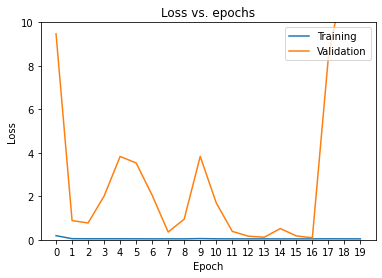

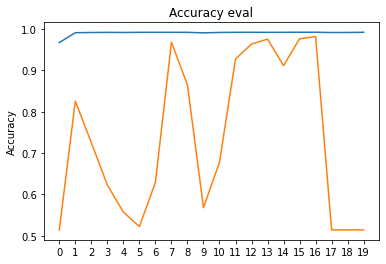

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
  

  plt.plot(history.history["accuracy"],label='train accuracy')
  plt.plot(history.history["val_accuracy"],label='test accuracy')
  plt.xticks(np.arange(0, 20, 1))
  plt.ylabel("Accuracy")
  # plt.legend(loc = "upper right")
  plt.title("Accuracy eval")
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xticks(np.arange(0, 20, 1))
  plt.ylim(0,10)
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()


plot_loss(hist)
plot_accuracy(hist)

In [ ]:
resnet.evaluate(x_test, y_test, batch_size=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import os,sys 
sys.path.append(os.pardir)




for i in [16,17]:
  checkpoint_path = f'/content/drive/MyDrive/real_final_model/model_{i}.ckpt'
  print(checkpoint_path)
  eval_model = build_resnet(num_cnn_list=[3,3,3,3,3], channel_list=[16,32,64,128,256])
  eval_model.load_weights(checkpoint_path)
  eval_model.compile(optimizer ='Adam', loss='binary_crossentropy', metrics=['accuracy'])
  eval_model.evaluate(x_test, y_test)

/content/drive/MyDrive/real_final_model/model_16.ckpt
75/75 [==============================] - 4s 33ms/step - loss: 0.1176 - accuracy: 0.9821
/content/drive/MyDrive/real_final_model/model_17.ckpt
75/75 [==============================] - 3s 30ms/step - loss: 0.0541 - accuracy: 0.9879
